In [ ]:
# default_exp data.load_pd

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [ ]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [ ]:
# export
import numpy as np
import pandas as pd

In [ ]:
# export
class TSMulti(MultiTuple):pass

In [ ]:
def get_df(length = [100,120]):
    dct = {'x':[],'con_ts_1':[],'con_ts_0':[],'cat_ts_1':[],'cat_ts_0':[],'con_0':[],'con_1':[], 'cat_0':[],'cat_1':[]}
    for i, l in enumerate(length):
        assert int(l/2) == l/2
        dct['x'].append(np.arange(l))
        dct['con_ts_0'].append(np.ones(l)[None,:])
        dct['con_ts_1'].append(pd.Series(np.arange(l)+np.random.randn(l)))
        dct['con_0'].append(np.random.randn())
        dct['con_1'].append(10+np.random.randn()*2)
        dct['cat_ts_0'].append(L(['a','b']*int(l/2)))
        dct['cat_ts_1'].append(L(['david','john']*int(l/2)))
        dct['cat_0'].append(['a','b'][i%2])
        dct['cat_1'].append(['adam','rdam'][i%2])
    return pd.DataFrame(data=dct)
df = get_df([10,12,6])
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 0.726027 1 -1.029554 2 3.488056 3 1.911253 4 4.579226 5 2.864858 6 7.345801 7 6.824938 8 7.503228 9 8.531310 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b]",2.066532,9.270302,a,adam
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0 -1.588961 1 2.009369 2 3.840425 3 3.519160 4 2.976543 5 5.851354 6 5.938467 7 6.172038 8 7.486624 9 8.594739 10 9.037131 11 10.678901 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b, a, b]",-0.312962,11.450261,b,rdam
2,"[0, 1, 2, 3, 4, 5]",0 -0.955997 1 0.045477 2 1.262736 3 3.424546 4 3.841304 5 6.494542 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john]","[a, b, a, b, a, b]",0.162616,12.130190,a,adam


## Transform catagorical data

In [ ]:
# export
class TensorCatI(TensorBase):pass
class CatSeqI(TensorSeqs):pass
def unpack_list(o, r=None):
    r = ifnone(r,L())
    for a in o:
        if isinstance(a,list) or isinstance(a,L):
            r = unpack_list(a, r)
        else:
            r.append(a)
    return r
            
class CatTfm(Transform):
    def __init__(self, df, cat_cols:[]): # maybe change to proccs
        self.vocab,self.o2i = {},{}
        for i, col in enumerate(L(cat_cols)):
            r = unpack_list(list(df[col]))
            self.vocab[col], self.o2i[col] = uniqueify(r, sort=True, bidir=True)
        
    def encodes(self, x:TensorCat):
        r = []
        for i, (o, key) in enumerate(zip(x.o, x._meta['label'])):
            r.append(self.o2i[key][o])#TensorCat   
        return TensorCatI(r, label = x._meta['label'])
    
    def decodes(self, x:TensorCatI): 
        r = []
        for i,(o, key) in enumerate(zip(x,x._meta['label'])):
            r.append(self.vocab[key][o]) #TensorCat   
        return TensorCat(r, label = x._meta['label'])
    
    def encodes(self, x:CatSeq):
        r = []
        for i,(o, key) in enumerate(zip(x.o,x._meta['label'])):
            r.append([])
            for a in o: 
                r[i].append(self.o2i[key][a]) #CatSeq        
        return CatSeqI(r, label = x._meta['label'])
    
    def decodes(self, x:CatSeqI):
        r = []        
        for i, (o, key) in enumerate(zip(x,x._meta['label'])):
            r.append([])
            for a in o:
                r[i].append(self.vocab[key][a])  
        return CatSeq(r, label = x._meta.get('label',None))
    
    

In [ ]:
o = CatSeq([['y','z','z','z'],['adam','rdam','adam','rdam']], label = ['cat_ts_1', 'cat_ts_0'])
df = pd.DataFrame({'cat_ts_1':[[i] for i in 'xzy'],'cat_ts_0':[[i] for i in ['adam','rdam','adam']],
                   'cat':['john','john','david'], 'cat1':['_john','_john','_david']})
tmf = CatTfm(df, ['cat_ts_0','cat_ts_1','cat','cat1'])
tmf(o)
o = TensorCat(['david','_john'], label = ['cat','cat1'])
tmf(o)


TensorCatI([0, 1])

In [ ]:
df = pd.DataFrame({'a':[[i,'a'] for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o = CatSeq([['a','b','a','a']], label='a')
o_tmf = tmf(o)
test_eq(o_tmf, TensorCatI([[0, 1, 0, 0]]))
test_eq(o_tmf._meta['label'], 'a')
dec_o = tmf.decode(o_tmf)
test_eq(dec_o,o)
dec_o

CatSeq([['a', 'b', 'a', 'a']], label = ['a'])

In [ ]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a'], label='a'))
test_eq_type(o_tmf,TensorCatI([0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a'],label = 'a'))

o_tmf = tmf(TensorCat(['b'], label='a'))
test_eq_type(o_tmf,TensorCatI([1]))
test_eq(tmf.decode(o_tmf),TensorCat(['b'],label='a'))

In [ ]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b'], label = ['a','a_2']))
test_eq_type(o_tmf,TensorCatI([0,0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b'],label = 'a'))

In [ ]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o = CatSeq([['a','b','a','a'],['b','b','c','c']], label=['a','a_2'])
o_tmf = tmf(o)
print(o_tmf)
test_eq(o_tmf, CatSeqI([[0, 1, 0, 0],
                        [0, 0, 1, 1]]))
test_eq(o_tmf._meta['label'], ['a','a_2'])
dec_o = tmf.decode(o_tmf)
test_eq(dec_o,o)
dec_o

CatSeqI([[0, 1, 0, 0],
        [0, 0, 1, 1]])


CatSeq([['a', 'b', 'a', 'a'], ['b', 'b', 'c', 'c']], label = ['a', 'a_2'])

In [ ]:
# export
class TSMulti_(Tuple):pass

class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, *args, **kwargs): # maybe change to proccs
        self.f = CatTfm(*args, **kwargs)
        
    def encodes(self, o:TSMulti):
        return TSMulti_(self.f(a) for a in o)
    
    def decodes(self, o:TSMulti_): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [ ]:
df = get_df([14,14])
tmf = CatMultiTfm(df,['cat_ts_1', 'cat_ts_0', 'cat_0','cat_1'])
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",0 -0.008268 1 1.135010 2 2.388784 3 1.553081 4 5.148497 5 6.223118 6 5.290037 7 8.014614 8 6.543943 9 10.994782 10 10.193349 11 13.146312 12 11.949216 13 13.922432 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b, a, b, a, b]",-0.149881,9.126949,a,adam
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",0 1.453564 1 -0.668634 2 2.280636 3 3.089876 4 2.548883 5 5.236884 6 5.602939 7 7.362093 8 8.322536 9 8.939030 10 11.693182 11 11.455225 12 11.052746 13 13.646016 dtype: float64,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b, a, b, a, b]",0.031681,7.659575,b,rdam


In [ ]:
o = TSMulti(TensorBase([1]), TensorCat(['adam','b'],label=['cat_1','cat_0']), 
            CatSeq([['david','david'],['a','b']], label=['cat_ts_1','cat_ts_0']))
o_tmf = tmf(o)
test_eq(o_tmf,(TensorBase([1]), TensorCatI([0,1]), CatSeqI([[0,0],[0,1]])))
o_b =tmf.decode(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))

# Dataloader

## pred

In [ ]:
# export
def array2series(o):
    return pd.Series(o.flatten())
def arrays2series(s:pd.Series):
    return pd.Series([array2series(o) for o in s])

In [ ]:
df = pd.DataFrame(data={'x':  [np.arange(10.),
                               np.arange(12.)],
                       'ts_0':[np.ones(10)[None,:],
                               np.ones(12)[None,:]],
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [ ]:
# hide
df = pd.DataFrame(data={'x':  [np.arange(10.)]*100,
                       'ts_0':[np.ones(10)[None,:]]*100,
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [ ]:
# export
def reconize_cols(dataset, col_types = {}):
    con_names, cat_names, con_ts_names, cat_ts_names, classes = L(), L(), L(), L(), {}
    for col in dataset.columns:
        t = type(dataset[col].iloc[0])
        if t is pd.core.series.Series:
            con_ts_names.append(col)
        elif t is np.ndarray:
            o = arrays2series(dataset[col])
            dataset[col] = o
            con_ts_names.append(col)
        elif isinstance(dataset[col].iloc[0], str):
            cat_names.append(col)
            classes[col] = uniqueify(list(dataset[col].values))
        elif isinstance(dataset[col].iloc[0], float) or isinstance(dataset[col].iloc[0], int) or t is np.int64:
            con_names.append(col)            
        elif (isinstance(dataset[col].iloc[0], L) or isinstance(dataset[col].iloc[0],list)) and isinstance(dataset[col].iloc[0][0],str):
            cat_ts_names.append(col)
            classes[col] = uniqueify(unpack_list(list(dataset[col])))
        else:
            raise Exception(t)
    return con_names, cat_names, con_ts_names, cat_ts_names, classes, dataset

In [ ]:
df = get_df()
con_names, cat_names, con_ts_names, cat_ts_names, classes, dataset = reconize_cols(df)
test_eq(con_names, ['con_0','con_1'])
test_eq(cat_names, ['cat_0','cat_1'])
test_eq(set(con_ts_names), set(['x','con_ts_0','con_ts_1']))
test_eq(set(cat_ts_names), set(['cat_ts_0','cat_ts_1']))
test_eq(classes, {'cat_ts_0': ['a','b'],
                  'cat_ts_1': ['david','john'],
                  'cat_0': ['a','b'],
                  'cat_1': ['adam','rdam']
                 })
con_names, cat_names, con_ts_names, cat_ts_names

((#2) ['con_0','con_1'],
 (#2) ['cat_0','cat_1'],
 (#3) ['x','con_ts_1','con_ts_0'],
 (#2) ['cat_ts_1','cat_ts_0'])

In [ ]:
list([L([a for a in o]) for o in df[['cat_ts_0','cat_ts_1']].values])

[(#2) [(#100) ['a','b','a','b','a','b','a','b','a','b'...],(#100) ['david','john','david','john','david','john','david','john','david','john'...]],
 (#2) [(#120) ['a','b','a','b','a','b','a','b','a','b'...],(#120) ['david','john','david','john','david','john','david','john','david','john'...]]]

In [ ]:
# export
class PrepDF(TabularProc):
    def setup(self, dl, train_setup):
        # speed up retrival
        dl.con = dl.dataset.loc[:,dl.con_names].values.astype(float)
        dl.cat = [list(dl.dataset.loc[i,dl.cat_names]) for i in range(dl.dataset.shape[0])]
        if len(dl.con_ts_names):
            dl.tsx_con = [np.concatenate([o[None,:] for o in dl.dataset.loc[i,dl.con_ts_names].values]) for i in range(dl.dataset.shape[0])]
        else:
            dl.tsx_con = [np.empty([0,0]) for i in range(dl.dataset.shape[0])]
            
        if len(dl.cat_ts_names):
            dl.tsx_cat = list([L([a for a in o]) for o in df[dl.cat_ts_names].values])
        else:
            dl.tsx_cat = ['']*dl.dataset.shape[0]   
        assert len(dl.cat) == len(dl.tsx_con) == dl.con.shape[0] == len(dl.tsx_cat), f"{len(dl.cat)} == {len(dl.tsx_con)} == {dl.con.shape[0]} == {len(dl.tsx_cat)}"
        return dl

In [ ]:
class test_dl(TfmdDL):    
    def __init__(self, dataset:pd.DataFrame, y_name, lookback = 10, horizon=3,step=1,min_seq_len=None):
        con_names, cat_names, con_ts_names, cat_ts_names, classes, dataset = reconize_cols(dataset)  
        store_attr(self,'lookback,horizon,step,y_name,con_names,cat_names,con_ts_names,cat_ts_names,classes,dataset')     
        assert y_name in self.con_ts_names, {k:getattr(self,k) for k in 'con_names,cat_names,con_ts_names,cat_ts_names'.split(',')}
        self.con_ts_names.remove(y_name) 
        PrepDF().setup(self, True)    
        self.min_seq_len = ifnone(min_seq_len, lookback)
        
df = get_df()
dl = test_dl(df, 'x')
test_eq(dl.cat,[['a', 'adam'], ['b', 'rdam']])
test_eq(dl.con.shape,(2,2))
test_eq(dl.tsx_con[0].shape, [2,100])
test_eq(len(dl.tsx_cat), 2)
test_eq(len(dl.tsx_cat[0]), 2)
test_eq(len(dl.tsx_cat[0][0]), 100)
dl.tsx_cat

[(#2) [(#100) ['david','john','david','john','david','john','david','john','david','john'...],(#100) ['a','b','a','b','a','b','a','b','a','b'...]],
 (#2) [(#120) ['david','john','david','john','david','john','david','john','david','john'...],(#120) ['a','b','a','b','a','b','a','b','a','b'...]]]

In [ ]:
for cols in [['x'],['x','cat_ts_0'],['x','con_ts_1'],['x','cat_1'],['x','con_0']]:
    print(cols)
    df = get_df()[cols]
    dl = test_dl(df, 'x')


['x']
['x', 'cat_ts_0']
['x', 'con_ts_1']
['x', 'cat_1']
['x', 'con_0']


In [ ]:
# export
def same_size_ts(ts:pd.Series, ts_names, _raise = True):
    shapes = {k:ts[k].shape if hasattr(ts[k],'shape') else (len(ts[k]),) for k in ts_names}
    all_same = [[(shapes[c] == shapes[a]) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)
    if _raise:
        assert np.sum(mask) == len(ts_names)**2, shapes
    return np.sum(mask) == len(ts_names)**2
    

In [ ]:
df = get_df()
con_names, cat_names, con_ts_names, cat_ts_names, classes, dataset = reconize_cols(df)
same_size_ts(dataset.iloc[0,:], ['x','con_ts_0','con_ts_1','cat_ts_0'])

True

In [ ]:
# hide
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1'], False),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1'], False),False)

In [ ]:
# export
def make_ids(dl):
    """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
    # Slice each time series into examples, assigning IDs to each
    last_id = 0
    n_dropped = 0
    n_needs_padding = 0
    dl._ids = {}
    for i, ts in dl.dataset.iterrows():
        same_size_ts(ts, dl.con_ts_names + dl.cat_ts_names)
        num_examples = (ts[dl.y_name].shape[-1] - dl.lookback - dl.horizon + dl.step) // dl.step
        # Time series shorter than the forecast horizon need to be dropped.
        if ts[dl.y_name].shape[-1] < dl.min_seq_len:
            n_dropped += 1
            continue
        # For short time series zero pad the input
        if ts[dl.y_name].shape[-1] < dl.lookback + dl.horizon:
            n_needs_padding += 1
            num_examples = 1
        for j in range(num_examples):
            dl._ids[last_id + j] = (i, j * dl.step)
        last_id += num_examples

    # Inform user about time series that were too short
    if n_dropped > 0:
        print("Dropped {}/{} time series due to length.".format(
                n_dropped, len(dl.dataset)))

    # Inform user about time series that were short
    if n_needs_padding > 0:
        print("Need to pad {}/{} time series due to length.".format(
                n_needs_padding, len(dl.dataset)))
    # Store the number of training examples
    dl.n = int(dl._ids.__len__() )
    return dl, int(dl._ids.__len__() )
    

In [ ]:
df = get_df([14,14,16])
dl = test_dl(df, 'x', lookback= 10,horizon = 2)
dl, n = make_ids(dl)
test_eq(dl._ids,{0: (0, 0),
                 1: (0, 1),
                 2: (0, 2),
                 3: (1, 0),
                 4: (1, 1),
                 5: (1, 2),
                 6: (2, 0),
                 7: (2, 1),
                 8: (2, 2),
                 9: (2, 3),
                 10: (2, 4)
                })

In [ ]:
# export
@typedispatch
def get_part_of_ts(x, lookback_id, length, pad=np.mean, t = tensor, **kwargs):
#     if len(x.shape) == 1:
#         x = x[None,:]
#     if isinstance(x[0,0],int):
#         x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = t(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        ), **kwargs).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = t(x[:,lookback_id:lookback_id + length], **kwargs).float()
    return x


In [ ]:
x = np.vstack([np.arange(10.)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10.)[None,:]
test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

In [ ]:
# hide
x = np.arange(10.)[None,:]
o =get_part_of_ts(x, 0, 11, t = TensorBase, label='a')
test_eq_type(o, TensorBase([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])) 
test_eq(o._meta, {'label':'a'})

In [ ]:
# export
@typedispatch
def get_part_of_ts(x:L, lookback_id, length, t = L, **kwargs):
    if len(x[0]) < length:
        # If the time series is too short, we pad
        padding = [o[-1] for o in x]
        pad_len = length - len(x[0])
        x = t(L(o[lookback_id:lookback_id + length] + [padding[i]]*pad_len) for i,o in enumerate(x))
    else:
        x = t([o[lookback_id:lookback_id + length] for o in x], **kwargs)
    return x

In [ ]:
x = L(['a','b']*5,['z','x']*5)
o =get_part_of_ts(x, 1, 5)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),L)

In [ ]:
x = L(['a','b']*2, ['z','x']*2)
o =get_part_of_ts(x, 0, 5)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),L)

In [ ]:
# export
from fastseq.core import *
def get_id(dl, ts_id, lookback_id):
    y = get_part_of_ts(dl.dataset.loc[ts_id, dl.y_name].values[None,:], lookback_id, dl.lookback + dl.horizon,
                       t = TensorSeqs, label=[dl.y_name + '_y'], m=['g'])
    x = TensorSeqs(y[:,:dl.lookback], label=[dl.y_name + '_x'], m=['g'])
    if len(dl.con_ts_names):
        tsx_con = get_part_of_ts(dl.tsx_con[ts_id], lookback_id, dl.lookback + dl.horizon,
                             t = TensorSeqs, label=dl.con_ts_names)
    else: tsx_con = TensorSeqs(np.empty([0]), label=[dl.con_ts_names])
    if len(dl.cat_ts_names):
        tsx_cat = get_part_of_ts(dl.tsx_cat[ts_id], lookback_id, dl.lookback + dl.horizon,
                             t = CatSeq, label=dl.cat_ts_names)
    else: tsx_cat = CatSeq('', label=dl.cat_ts_names)
        
    r = [x, tsx_con, tsx_cat]
    r.append(TensorCat(dl.cat[ts_id], label=dl.cat_names))
    r.append(TensorCon(dl.con[ts_id,:], label=dl.con_names))      
    r.append(y)
    return tuple(r)

In [ ]:
df = get_df([14,14,16])
dl = test_dl(df, 'x', lookback= 10,horizon = 2)
dl, n = make_ids(dl)
for k, (ts_id, lookback_id) in dl._ids.items():
    r = get_id(dl, ts_id, lookback_id)

In [ ]:
df = get_df([14,14,16])
dl = test_dl(df.loc[:,['x']], 'x', lookback= 10,horizon = 2)
dl, n = make_ids(dl)
for k, (ts_id, lookback_id) in dl._ids.items():
    r = get_id(dl, ts_id, lookback_id)

## TfmDL

In [ ]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1,
                 min_seq_len=None, procs = None, train = True, **kwargs):
        con_names, cat_names, con_ts_names, cat_ts_names, classes, dataset = reconize_cols(dataset)  
        store_attr(self,'horizon,lookback,step,y_name,con_names,cat_names,con_ts_names,cat_ts_names,classes,dataset')     
        assert y_name in self.con_ts_names, {k:getattr(self,k) for k in 'con_names,cat_names,con_ts_names,cat_ts_names'.split(',')}
        self.con_ts_names.remove(y_name)         
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self, n = make_ids(self)
        kwargs['after_item'] = kwargs.get('after_item', CatMultiTfm(dataset, self.cat_names+self.cat_ts_names))
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.procs = Pipeline(PrepDF() +L(procs), as_item=True)
        self.procs.setup(self, train)            

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res, n = make_ids(res)
        res.n = n
        return res    
    
    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        ts_id, lookback_id = self._ids[idx]
        r  = get_id(self, ts_id, lookback_id) 
        return TSMulti(r)    

In [ ]:
df = get_df()
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]","0 -0.963077 1 2.213154 2 2.736372 3 1.734433 4 3.297529 ... 95 95.043852 96 95.777291 97 95.625458 98 96.852803 99 99.557989 Length: 100, dtype: float64","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, joh...","[a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b]",0.742957,6.906254,a,adam
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]","0 0.245929 1 -0.444525 2 3.761948 3 1.833373 4 3.685730 ... 115 113.909678 116 116.457124 117 116.529269 118 116.591843 119 119.297652 Length: 120, dtype: float64","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]]","[david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, john, david, joh...","[a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, 

In [ ]:
horizon,lookback = 2,4
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, num_workers=0)
for o in dl:
    pass

In [ ]:
def get_all():
    for o in dl:
        pass
import time
st = time.time()
get_all()
tot_time = time.time()-st
test_eq(tot_time<.265, True)
print(tot_time)

0.24933338165283203


In [ ]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, num_workers = 0)

for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),6)
    dct = {k:v for k,v in zip(['x','tsx','tsx_cat','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    test_eq(dct['tsx_cat'].shape[1:], (2,lookback+horizon))
    break
dl.classes['cat_0'] = L('a','b')

In [ ]:
# hide
# without cat or con
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_ts_0']], 'x', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),6)
    dct = {k:v for k,v in zip(['x','tsx','tsx_cat','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([0]))
    test_eq(dct['con'].shape[1:], ([0]))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx_cat'].shape[1:], [0])
    
test_eq(first(dl), dl.one_batch())

In [ ]:
# hide
# without tsx
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:, ['x','cat_0','con_0']], 'x', horizon = horizon, lookback = lookback, num_workers = 0)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),6)
    dct = {k:v for k,v in zip(['x','tsx','tsx_cat','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([1]))
    test_eq(dct['con'].shape[1:], ([1]))
    test_eq(dct['tsx'].shape[1:], ([0]))
    test_eq(dct['tsx_cat'].shape[1:], [0])
    
test_eq(first(dl), dl.one_batch())

In [ ]:
# hide
# test self.new
dl.new()

# Showing

In [ ]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

DfDataLoader.show_batch = _show_batch_class

In [ ]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeqs, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

In [ ]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(Tabular,object) -> show_batch
(object,object) -> show_batch

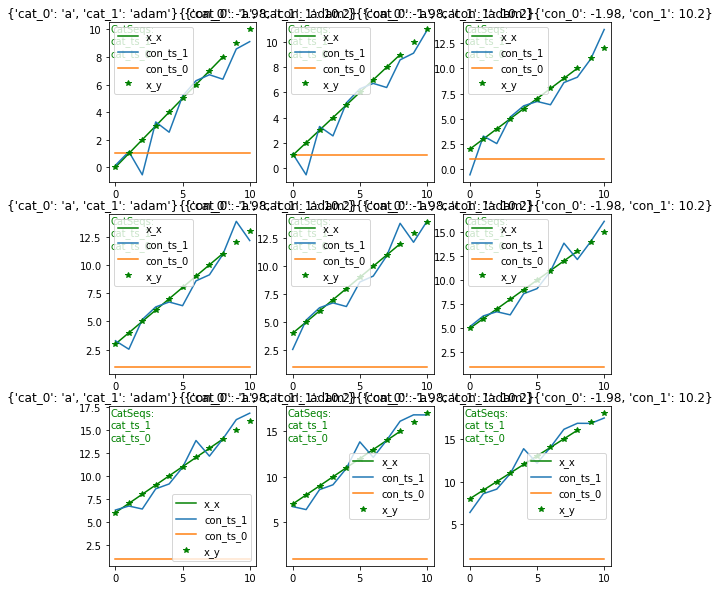

In [ ]:
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

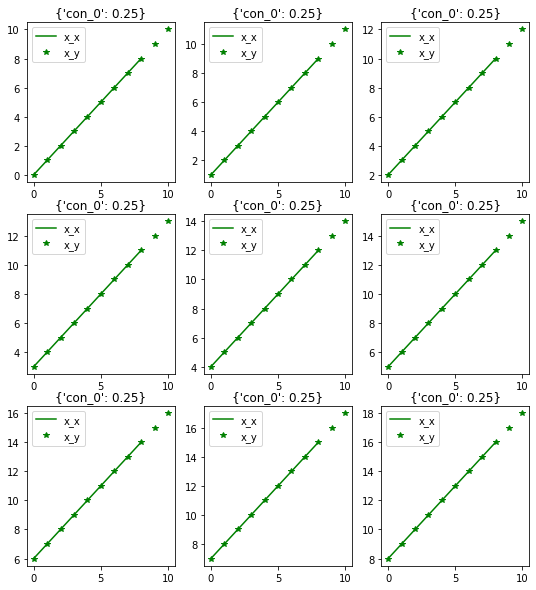

In [ ]:
# hide
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

In [ ]:
# export

# def _show_results_class(self, b, out, max_n=9, ctxs=None, show=True, **kwargs):
#     x,y,its = self.show_batch(b, max_n=max_n, show=False,)
#     x = self.after_item.decode(b)
#     b_out = b[:self.n_inp] + (tuple(out) if is_listy(out) else (out,))
#     x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
#     res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
#     if not show: return res
#     show_results(*res, ctxs=ctxs, max_n=max_n, **kwargs)
    
# DfDataLoader.show_results = _show_results_class

In [ ]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [ ]:
show_results

(TSMulti,object) -> show_results
(object,object) -> show_results

In [ ]:
a = TensorSeqs([0], label = ['a'])
a._meta

{'label': ['a']}

(#4) [0,23586984.0,8911637504.0,'00:00']


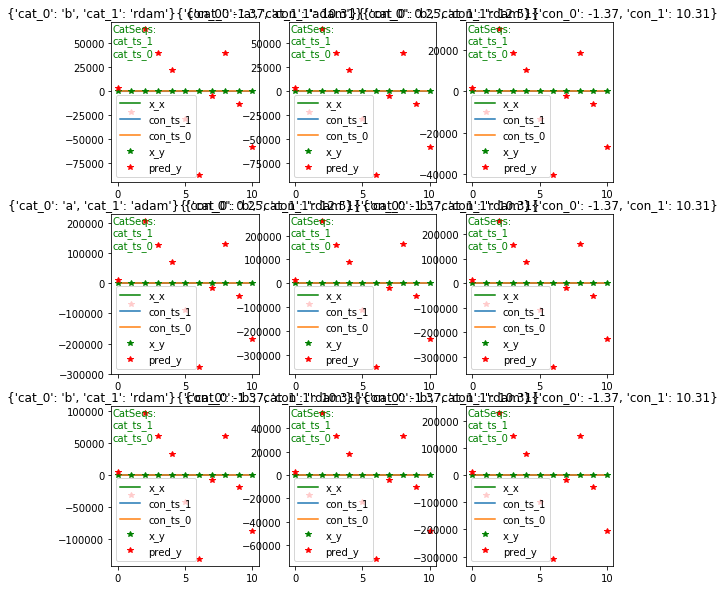

In [ ]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

(#4) [0,26720520.0,10095841280.0,'00:00']


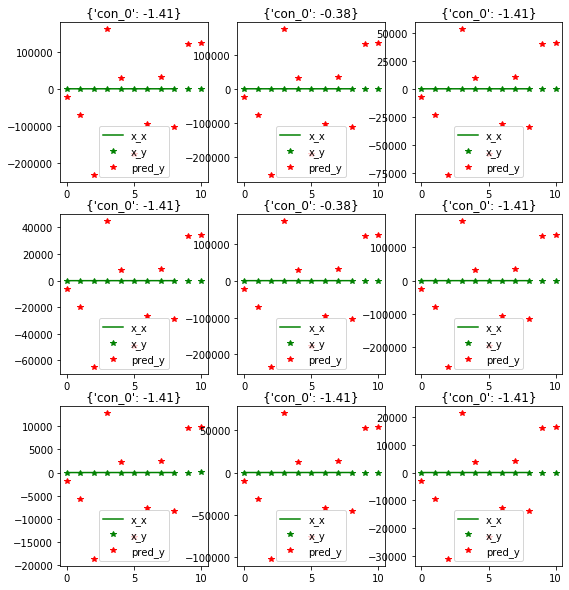

In [ ]:
# hide
# wo tsx
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

# Intergration Example

In [ ]:
from fastseq.data.external import *

In [ ]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df['city'] = df['city']
df.head()

,x,weather,city,cont
0,"[[1.7840994883378696, 1.6354397314474773, 0.9969616174649543, 1.0656108457418487, 0.8949552908255173, 0.6668031794640517, 0.43253013414213387, 0.4971411112252976, 0.7378041294534499, 0.6593568928986641, 0.6695648365262247, 0.35688993092480814, 0.0967280051310319, 0.10742317843841478, 0.4452224916727804, 0.7110482699493464, 0.5721753009592783, 0.44950935098515604, 0.352533807687249, 0.07357585942330061, -0.5002190856452365, -1.2950179502800305, -2.053885568263622, -2.1211260015191904, -1.9410495034870794, -1.3937972902650204, -1.1001811935064822, -0.9778029768399791, -0.4549284038881587, -0...","[[6.251908700912128, 6.044878194366063, 6.666979741533248, 7.885294702381225, 8.147978359712267, 6.781255814523704, 5.2658276971603435, 5.600256707849542, 7.74198828198216, 9.528117112529197, 9.276745539072946, 7.7305031925300325, 6.90834374377602, 7.533072072738499, 8.445642760150596, 8.542225451853287, 6.251908700912128, 6.044878194366063, 6.666979741533248, 7.885294702381225, 8.147978359712267, 6.781255814523704, 5.2658276971603435, 5.600256707849542, 7.74198828198216, 9.528117112529197, 9.276745539072946, 7.7305031925300325, 6.90834374377602, 7.533072072738499, 8.445642760150596, 8.542...",adam,-0.802940
1,"[[0.7950471648453499, 0.6214443727863806, 0.1581675541214118, 0.06251710428333954, 0.4297714247302602, 0.2898345699215736, 1.1119051774336675, 1.1357993981765926, 1.191288805448241, 1.0593112652903867, 0.16833319923344775, -0.28396427328926943, -0.9852698988772368, -1.779728351257704, -1.3430601257522121, -0.9497723555852047, -0.6898691433086384, 0.3483568893145593, 1.30717902273843, 1.9646024375744684, 1.635348055942205, 0.9730224456660352, 0.20916447097990695, -0.6360927152021107, -1.1690804971345272, -1.67917092224391, -1.681747349505977, -0.8791488949085068, -0.46820826534894805, -0.27...","[[6.416319376614406, 6.61437133676833, 6.9340528832995485, 7.2347340229878085, 7.388358068794967, 7.364181716649039, 7.249119082197803, 7.1902272593223655, 7.29739293717099, 7.570616115743676, 7.900010105892153, 8.138517813735332, 8.19922512362542, 8.112875339634412, 8.007525148800438, 8.023804544343761, 6.416319376614406, 6.61437133676833, 6.9340528832995485, 7.2347340229878085, 7.388358068794967, 7.364181716649039, 7.249119082197803, 7.1902272593223655, 7.29739293717099, 7.570616115743676, 7.900010105892153, 8.138517813735332, 8.19922512362542, 8.112875339634412, 8.007525148800438, 8.023...",adam,1.093776
2,"[[-0.3780713705657684, -0.4436555443589079, -0.7035461035855513, -0.7740609185887349, -0.7588895025536965, -0.6229458545249713, -0.7327143722050767, -0.32323289057029786, -0.41329193176613477, -0.7380584273333273, -0.7012040586015358, -0.43783807100870736, -0.2135399960988395, 0.36098598026692774, 0.5267236897390586, 0.9523364729950756, 0.8086613714650199, 0.9535865491348703, 0.6743786642024908, 0.5045530559150043, 0.00016005952989292283, -0.7127289731491673, -1.0001120157490548, -1.4570490108658687, -1.3389925222729173, -1.1530544873871913, -0.401854126286967, 0.4850287236384016, 1.379891...","[[3.4852960938232274, 3.3765336308839005, 3.708626655588652, 4.261019052219076, 4.759019069087293, 5.052866200687754, 4.978602235464441, 4.338239925203549, 3.2225686595019516, 2.241794904545716, 2.1568915959775437, 3.149529711313777, 4.557105142983309, 5.4612602183110175, 5.526480222798705, 5.189677125105871, 3.4852960938232274, 3.3765336308839005, 3.708626655588652, 4.261019052219076, 4.759019069087293, 5.052866200687754, 4.978602235464441, 4.338239925203549, 3.2225686595019516, 2.241794904545716, 2.1568915959775437, 3.149529711313777, 4.557105142983309, 5.4612602183110175, 5.526480222798...",adam,1.401380
3,"[[-0.30532224931601015, -0.38664453396932547, -0.6175941817679635, 0.03144793998158291, 0.16392970572982826, 0.05738700494708432, -0.04534792705426382, 0.31235628469289184, 0.8701359035560363, 0.886594934793418, 0.07687391386956846, -1.2951074630299253, -1.972272213398826, -1.8779366431213642, -1.5972917333168393,

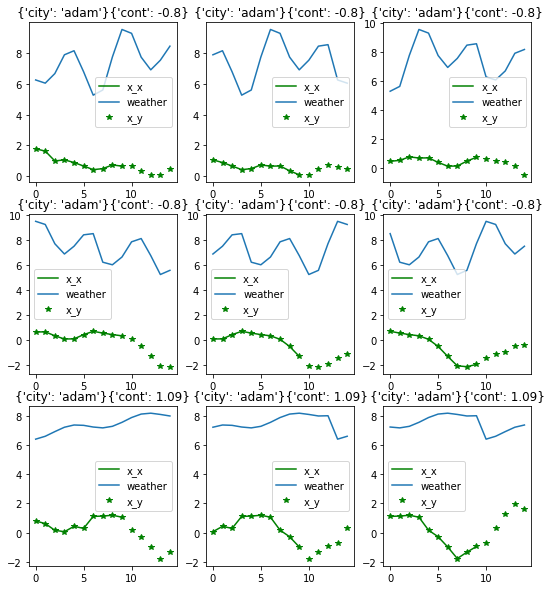

In [ ]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

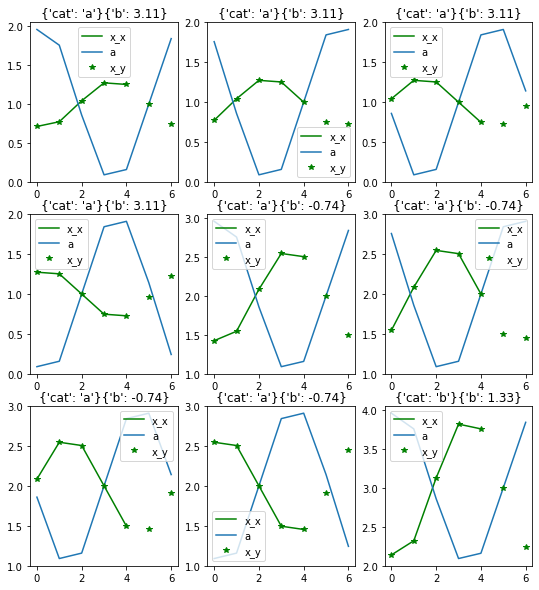

In [ ]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
#                   after_batch = NormalizeTSMulti(),
                  num_workers = 1)
dl.show_batch()

# M5 Example

In [ ]:
path = Path('../data/m5_tiny')
path.ls()

(#6) [Path('../data/m5_tiny/sales_train_validation.csv'),Path('../data/m5_tiny/sample_submission.csv'),Path('../data/m5_tiny/calendar.csv'),Path('../data/m5_tiny/prices.csv'),Path('../data/m5_tiny/calender_d.csv'),Path('../data/m5_tiny/sell_prices.csv')]

In [ ]:
df_cal = pd.read_csv(path / 'calendar.csv')
df_cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
df_cal[[c for c in df_cal if 'event' not in c]]

,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,0,0,0


In [ ]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:100,:]

In [ ]:
# export
def _to_series(df, s_slice=None, add_zeros = 28*2):
    s_slice = ifnone(s_slice, slice(6,None))
    r = []
    for i in range(df.shape[0]):
        r.append(pd.Series(np.concatenate([df.iloc[i, s_slice].values.astype(float),[0]*add_zeros]) ))
    return r

@delegates(_to_series)
def to_contained_series(df, series_column_name = 'sales', **kwargs):    
    data={k:v for k,v in dict(df).items() if ('d_' not in k and 'F' not in k)}
    data[series_column_name] = pd.Series(_to_series(df, **kwargs))
    df = pd.DataFrame(data=data)
    return df

In [ ]:
df_sales_s = to_contained_series(df_sales)

In [ ]:
df_validation = to_contained_series(pd.read_csv(path / 'sample_submission.csv'),
                                    s_slice=slice(1,None), add_zeros = 0) 
df_validation.head()

,id,sales
0,HOBBIES_1_001_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64
1,HOBBIES_1_002_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64
2,HOBBIES_1_003_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64
3,HOBBIES_1_004_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64
4,HOBBIES_1_005_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64


In [ ]:
lookback, horizon = 28*2, 28
def _id(row):
    return '_'.join(str(row['id']).split('_')[:-1])

df_sales_s_last = to_contained_series(pd.read_csv(path / 'sales_train_validation.csv'),
                                    s_slice=slice(-lookback,None), add_zeros = 28*2)  
df_sales_s_last['sales'] = pd.Series(np.concatenate([df_sales_s_last['sales'].values,[0]*28]))
df_sales_s_last['sales'] = pd.Series(np.concatenate([df_sales_s_last['sales'].values,[0]*28]))
df_sales_s_last.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,"0 0.0 1 2.0 2 0.0 3 1.0 4 1.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,"0 0.0 1 0.0 2 0.0 3 1.0 4 0.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,"0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,"0 0.0 1 0.0 2 0.0 3 1.0 4 0.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,"0 1.0 1 2.0 2 1.0 3 0.0 4 0.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"


In [ ]:
for i,row in df_validation.iterrows():
    id = '_'.join(str(row['id']).split('_')[:-1])
    c_row = df_sales_s[df_sales]
    break

ValueError: Boolean array expected for the condition, not object

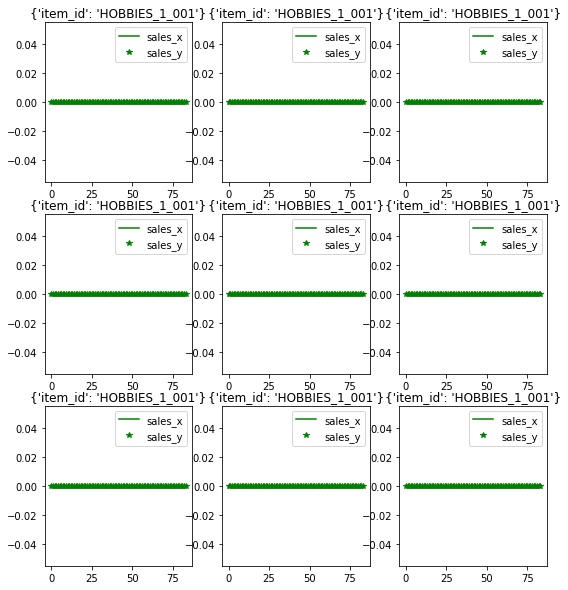

In [ ]:
dl =  DfDataLoader(df_sales_s.loc[:,['sales','item_id']], 'sales', horizon = 28, lookback=28*2, step=7)
dl.show_batch(max_n=9)

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 030_data.m5.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [ ]:
git_add('020_data.load_pd.ipynb', commit_msg='added series_column_name arg')

Converted 020_data.load_pd.ipynb.


['/home/tako/dev/fastseq/fastseq/data/load_pd.py',
 '/home/tako/dev/fastseq/nbs/020_data.load_pd.ipynb']